# Demo II - Global Spatial-Temporal features for Variables

In this experiment, I look at how one can look at the spatial-temporal feature inclusion for different variables. We know that there is a spatial temporal relationship when it comes to using data as inputs. Now we would like to investigate how this changes depending on each variable in terms of information theory.

In [9]:
import os, sys
cwd = os.getcwd()
source_path = f"{cwd}/../"
sys.path.insert(0, f'{source_path}')

# Import RBIG Helper
from src.models.train_models import run_rbig_models

# Import shapefile helper
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
from esdc.shape import ShapeFileExtract, rasterize
from esdc.data import MiniCubes


import pandas as pd
import xarray as xr
from tqdm import tqdm
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

I will use the same exploratory datasets that I looked at in the paper because they exhibited the greatest difference in the pattern:

* Precipitation
* Water Vapour
* Root Moisture

For essence of time and space, I will be conducting the experiment over the following regions:

* Europe

In [2]:
!ls /media/disk/databases/BACI-CABLAB/low_res_data/water_vapour/

2001_water_vapour.nc  2004_water_vapour.nc  2007_water_vapour.nc
2002_water_vapour.nc  2005_water_vapour.nc  2008_water_vapour.nc
2003_water_vapour.nc  2006_water_vapour.nc


In [3]:
rm_path = "/media/disk/databases/BACI-CABLAB/low_res_data/root_moisture/"
precip_path = "/media/disk/databases/BACI-CABLAB/low_res_data/precipitation/"
wv_path = "/media/disk/databases/BACI-CABLAB/low_res_data/water_vapour/"

paths = [rm_path, precip_path, wv_path]
names = ['root_moisture', 'precipitation', 'water_vapour']

# Load all datacubes and extract relevant variables
cubes = list()

for iname, ipath in zip(names, paths):
    cubes.append(xr.open_mfdataset(f"{ipath}*", combine='by_coords')[iname])

In [4]:
datacube = xr.merge(cubes, )

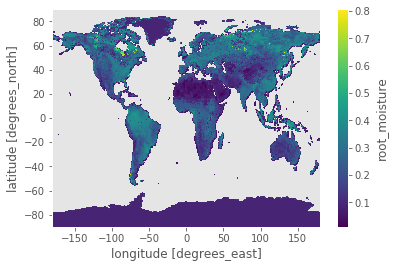

In [5]:
datacube.root_moisture.mean('time').plot()

### Shape Files

In order to segment a region of the datacube, we can use shape files. I will downlo

In [6]:
shapefiles_clf = ShapeFileExtract()

# download shapefile data
shp_file_path = f"{cwd}/../data/shape_files/countries/"

shapefiles_clf.download_shape_files(shp_file_path, overwrite=False);

File already exists:
'/home/emmanuel/projects/2019_ci_rbig/notebooks/../data/shape_files/countries/country_shp.zip'


In [7]:
# Extract Europe
query = 'CONTINENT'
subqueries = ['Europe']

euro_geoms =  shapefiles_clf.extract_polygons(query=query, subqueries=subqueries)

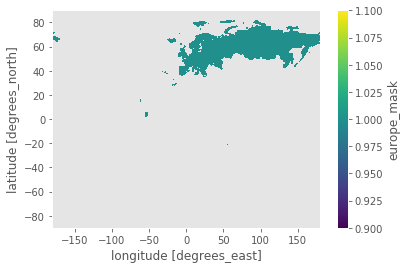

In [10]:
# Add mask to datacube
datacube.coords['europe_mask'] = rasterize(euro_geoms, datacube)

# plot the mask
datacube.europe_mask.plot()

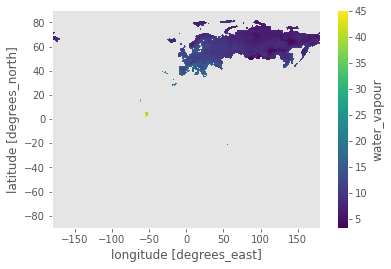

In [11]:
# plot the variable with the mask
datacube.water_vapour.where(datacube.europe_mask >= 1).mean('time').plot()

### MiniCubes

#### Spatial 1x1, Temporal 12

In [14]:
spatial_res = 1
temporal_res = 12

minicuber_clf = MiniCubes(
    spatial_window=spatial_res,
    time_window=temporal_res
)

minidf = minicuber_clf.get_minicubes(datacube.water_vapour.where(datacube.europe_mask >= 1))

minidf.head()

var_x0    var_x1    var_x2    var_x3    var_x4  \
time       lat    lon                                                         
2001-04-03 59.875 18.125   8.077401  8.077401  8.077401  3.896598  5.803762   
                  18.375   8.077401  8.077401  8.077401  3.896598  5.803762   
                  18.625   8.167150  8.167150  8.167150  3.945212  5.953344   
                  18.875   8.167150  8.167150  8.167150  3.945212  5.953344   
                  126.625  1.944559  1.944559  1.944559  0.989108  2.213806   

                             var_x5    var_x6    var_x7    var_x8    var_x9  \
time       lat    lon                                                         
2001-04-03 59.875 18.125   5.803762  5.803762  3.406719  7.419242  7.419242   
                  18.375   5.803762  5.803762  3.406719  7.419242  7.419242   
                  18.625   5.953344  5.953344  3.668486  8.167150  8.167150   
                  18.875   5.953344  5.953344  3.668486  8.167150  8.167150   
                  126.625  2.213806  2.213806  1.406066  3.171128  3.171128   

                            var_x10   var_x11  
time       lat    lon                          
2001-04-03 59.875 18.125   7.419242  5.033418  
                  18.375   7.419242  5.033418  
                  18.625   8.167150  5.429808  
                  18.875   8.167150  5.429808  
                  126.625  3.171128  1.765062

In [18]:
# normalize data
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(minidf)

In [ ]:
# perform RBIG, Entropy, Total Correlation
tc1_, h1_, h_t1_ = run_rbig_models(X, measure='t', verbose=None)